In [0]:
#libraries for data processing
import numpy as np
import pandas as pd

#for data importing
from google.cloud import bigquery
import google.auth

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#different
import warnings
warnings.filterwarnings('ignore')

Creating bigquery API client for data importing. For the authorisation will be used special service account - the .json keys can be found in the root of repository with name service_key.json.

In [0]:
try:
  # if service key file uploaded to Google drive and drive mounted to the collab
  bq_client = bigquery.Client.from_service_account_json('/content/drive/My Drive/Colab Notebooks/service_key.json')
except FileNotFoundError:
  # for running the repository content on local machine
  bq_client = bigquery.Client.from_service_account_json('./service_key.json')

Collecting the initial piece of data (10k rows) to explore the structure and values of data:

In [40]:
init_query = "SELECT * FROM bigquery-public-data.iowa_liquor_sales.sales LIMIT 10000"
init_df = bq_client.query(init_query).result().to_dataframe()
init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
invoice_and_item_number    10000 non-null object
date                       10000 non-null object
store_number               10000 non-null object
store_name                 10000 non-null object
address                    9959 non-null object
city                       9959 non-null object
zip_code                   9959 non-null object
store_location             9069 non-null object
county_number              9929 non-null object
county                     9929 non-null object
category                   9670 non-null object
category_name              9622 non-null object
vendor_number              10000 non-null object
vendor_name                10000 non-null object
item_number                10000 non-null object
item_description           10000 non-null object
pack                       10000 non-null int64
bottle_volume_ml           10000 non-null int64
state_bottle_cost   

In [41]:
init_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons
0,S14073400068,2013-10-11,2806,Osco #881 / Clinton,1307 N SECOND,CLINTON,52732,POINT (-90.184797 41.858932),23,Clinton,1701100,DECANTERS & SPECIALTY PACKAGES,461,Campari(skyy),2916,Carolan's Irish Cream w/2 Glasses,6,750,7.70,11.55,18,207.90,13.50,3.57
1,INV-00074400011,2016-08-31,5176,Smokin' Joe's #15 Tobacco & Liquor O,"455, Edgewood Rd NW",Cedar Rapids,52405,POINT (-91.715903 41.97805),57,LINN,1031000,American Vodka,300,McCormick Distilling Co.,36904,Mccormick Vodka Pet,24,375,1.80,2.70,1,64.80,0.37,0.09
2,INV-17044200004,2019-01-22,4677,Costco Wholesale #1111 / Coralville,2900 Heartland Dr,Coralville,52241,POINT (-91.61494100000002 41.698028),52,JOHNSON,1032000,Imported Vodka,217,MISA Imports Inc,987514,Kirkland Signature French Vodka,6,1750,14.48,21.72,576,12510.72,1008.00,266.28
3,INV-17127900040,2019-01-24,4877,World Liquor & Tobacco,1775 NW 86th St,Clive,50325,POINT (-93.736232 41.607853),77,POLK,1701100,Temporary & Specialty Packages,370,PERNOD RICARD USA,100444,Jameson w/2-50mls,6,850,15.99,23.99,6,143.94,5.10,1.34
4,S22019800059,2014-10-27,2539,Hy-Vee Food Store / iowa Falls,HIGHWAY 65 SOUTH,IOWA FALLS,50126,None,42,Hardin,1701100,DECANTERS & SPECIALTY PACKAGES,420,"Moet Hennessy USA, Inc.",561,Ardbeg 10YR Exploration Pack,6,850,25.98,38.97,6,233.82,5.10,1.35


In [42]:
print('\n'.join(list(init_df.columns)))
print('Columns q-ty: ' + str(len(init_df.columns)))

invoice_and_item_number
date
store_number
store_name
address
city
zip_code
store_location
county_number
county
category
category_name
vendor_number
vendor_name
item_number
item_description
pack
bottle_volume_ml
state_bottle_cost
state_bottle_retail
bottles_sold
sale_dollars
volume_sold_liters
volume_sold_gallons
Columns q-ty: 24


Looks like some items dataset contain repeatable data - category or name and syntetic identifier: <ul>
<li>store_number and store_name</li>
<li>county_number and county</li>
<li>category and category_name</li>
<li>vendor_number and vendor_name</li>
<li>item_number and item_description</li>
</ul>
Also, next set of columns contains null values so need to be handled during dataset upload:
<ul>
<li>address</li>
<li>city</li>
<li>zip_code</li>
<li>store_location</li>
<li>county_number</li>
<li>county</li>
<li>category</li>
<li>category_name</li>
<li>vendor_number</li>
</ul>
Dataset weight in Google Cloud storage - 4.68 GB, so size should be reduced to efficiently download and process it in RAM. In this case invoice_and_item_number column can be excluded from analysis. Also, columns which contains categorical data can be replaced with its syntetic analog.

In [43]:
init_df['synth_sales'] = init_df['state_bottle_retail'] * init_df['bottles_sold']
print(np.allclose(init_df['synth_sales'], init_df['sale_dollars'], atol=0.01))

False


Sale_dollars column should be the product of state_bottle_retail and bottles_sold columns, but somewhere in data is a difference, so np.allclose with tolerance 0.01 returns False. Filtering the part of dataset to review where the absolute value of difference is larger than given tolerance:

In [44]:
sales_diff_df = init_df[np.abs(init_df['synth_sales'] - init_df['sale_dollars']) > 0.01]
sales_diff_df.head()

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,synth_sales
1,INV-00074400011,2016-08-31,5176,Smokin' Joe's #15 Tobacco & Liquor O,"455, Edgewood Rd NW",Cedar Rapids,52405,POINT (-91.715903 41.97805),57,LINN,1031000,American Vodka,300,McCormick Distilling Co.,36904,Mccormick Vodka Pet,24,375,1.80,2.70,1,64.80,0.37,0.09,2.70
28,INV-00024800023,2016-08-29,5173,Audubon Food Land,104 Market St,Audubon,50025,POINT (-94.93625 41.723057),5,AUDUBON,1031000,American Vodka,434,LUXCO INC,36308,Hawkeye Vodka,6,1750,7.17,10.76,4,10.76,7.00,1.84,43.04
29,INV-00027400010,2016-08-30,4641,Kum & Go #573 / SE 14th DM,5830 SE 14th St,Des Moines,50315,None,77,POLK,1031000,American Vodka,260,DIAGEO AMERICAS,37991,Smirnoff Vodka 80 Prf Mini,12,500,7.47,11.21,4,11.21,2.00,0.52,44.84
30,INV-00045300045,2016-08-30,3993,New Star Liquor / W 4th S / Waterloo,1625 West 4th St,Waterloo,50701,None,7,BLACK HAWK,1070000,Cocktails / RTD,395,PROXIMO,58879,Jose Cuervo Golden Grapefruit Margarita,6,1750,10.49,15.74,3,15.74,5.25,1.38,47.22
43,INV-22319400029,2019-10-04,2558,Hy-Vee Food Store / Mount Pleasant,1700 E Washington,Mount Pleasant,52641,POINT (-91.52888 40.962331000000006),44,HENRY,1091200,Neutral Grain Spirits,434,LUXCO INC,41846,Everclear Alcohol,12,750,8.00,12.00,24,324.00,18.00,4.75,288.00


In [45]:
print(sales_diff_df.shape)
print("Differences in data {0: .2f}%".format(sales_diff_df.shape[0] / init_df.shape[0] * 100))

(425, 25)
Differences in data  4.25%


472 out of 10k - so column can't be excluded from query, this difference should be investigated. Additioanl review needed to decide which data are correct.

In [46]:
init_df[['volume_sold_gallons', 'volume_sold_liters']].corr()

,volume_sold_gallons,volume_sold_liters
volume_sold_gallons,1.0,1.0
volume_sold_liters,1.0,1.0


In [47]:
init_df['synth_volume'] = init_df['bottle_volume_ml'] * init_df['bottles_sold'] / 1000
print(np.allclose(init_df['synth_volume'], init_df['volume_sold_liters'], atol=0.01))

True


Columns volume_sold_gallons and volume_sold_liters are linear dependent (as expected) and are the combination of bottle_volume_ml and bottles_sold, so can be excluded from query.

Exploring the parameters of data in overall dataset to define correct data types:

In [0]:
data_descr_query = """
SELECT 
    COUNT(*) AS overall_rows,
    MAX(store_number) AS max_store_num,
    MAX(vendor_number) AS max_vendor_num,
    MAX(zip_code) AS max_zip,
    MAX(item_number) AS max_item_num,
    MAX(pack) AS pack_max,
    MAX(bottle_volume_ml) AS volume_max,
    MAX(state_bottle_cost) AS max_bottle_cost,
    MAX(state_bottle_retail) AS max_retail,
    MAX(bottles_sold) AS max_bottles_sold,
    MAX(sale_dollars) AS max_sale_dollars
FROM bigquery-public-data.iowa_liquor_sales.sales
"""

In [49]:
data_descr_df = bq_client.query(data_descr_query).result().to_dataframe()
data_descr_df

,overall_rows,max_store_num,max_vendor_num,max_zip,max_item_num,pack_max,volume_max,max_bottle_cost,max_retail,max_bottles_sold,max_sale_dollars
0,18098417,9938,987,80904,x904631,336,378000,7680.0,11520.0,15000,279557.28


In [0]:
dtypes = {'pack': np.int16, 'bottle_volume_ml': np.int32, 'state_bottle_cost': np.float32, 
          'state_bottle_retail': np.float32, 'bottles_sold': np.int16, 'zip_code': np.int32,
          'store_number': np.int16, 'vendor_number': np.int16, 'county_number': np.int32}

Creating the query in a way to replace the categorical null values by the specific identifier and converting columns which have non-numeric data types:

In [0]:
all_items_query = """
SELECT
    date,
    COALESCE(SAFE_CAST(store_number AS NUMERIC), -999) AS store_number,
    COALESCE(address, "NO ADDRESS") AS address,
    COALESCE(city,"NO CITY") AS city,
    COALESCE(SAFE_CAST(zip_code AS NUMERIC), -999) AS zip_code,
    COALESCE(store_location, "LOCATION UMKNOWN") AS store_location,
    COALESCE(SAFE_CAST(county_number AS NUMERIC), -999) AS county_number,
    COALESCE(category, "NO CATEGORY") AS category,
    COALESCE(SAFE_CAST(vendor_number AS NUMERIC), -999) AS vendor_number,
    COALESCE(SAFE_CAST(item_number AS NUMERIC), -999) AS item_number, 
    pack,
    bottle_volume_ml,
    state_bottle_cost,
    state_bottle_retail,
    bottles_sold,
    sale_dollars
FROM bigquery-public-data.iowa_liquor_sales.sales
"""

In [0]:
# if personal drive doesn't mounted to the collab - try to change address variable to your default
# working directory
address = r'/content/drive/My Drive/Colab Notebooks/full_dataset.csv'
try:
  all_items_df = pd.read_csv(address, dtype=dtypes)
except FileNotFoundError:
  all_items_df = bq_client.query(all_items_query).result().to_dataframe(dtypes=dtypes)
  try:
    all_items_df.to_csv(address)
  except:
    pass

The dataset is the history of the sales, so to ease working with it date column should be converted to index:

In [0]:
#changing the default index to datetime index
all_items_df['date'] = pd.to_datetime(all_items_df['date'])
all_items_df.set_index('date', inplace=True)

In [0]:
all_items_df.drop('Unnamed: 0', axis=1, inplace=True)

In [71]:
all_items_df.describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,store_number,zip_code,county_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,synth_sales
count,17926603.00,17926603.00,17926603.00,17926603.00,17926603.00,17926603.00,17926603.00,17926593.00,17926593.00,17926603.00,17926593.00,17926593.00
mean,3655.67,51010.31,48.04,259.03,46622.02,12.29,917.88,9.62,14.93,10.21,133.35,128.56
std,1001.58,3779.49,101.98,139.92,56890.78,7.62,675.68,10.45,15.74,27.17,456.02,449.01
min,2106.00,-999.00,-999.00,-999.00,-999.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,2612.00,50315.00,31.00,115.00,27025.00,6.00,750.00,5.50,8.25,2.00,31.41,31.36
50%,3756.00,51054.00,61.00,260.00,38177.00,12.00,750.00,8.07,12.29,6.00,70.56,70.56
75%,4452.00,52302.00,77.00,380.00,64676.00,12.00,1000.00,11.99,17.99,12.00,137.16,137.16
max,9938.00,80904.00,99.00,987.00,999449.00,336.00,378000.00,7680.00,11520.00,15000.00,279557.28,279557.28


In [55]:
all_items_df.nunique(axis=0)

Unnamed: 0             17926603
store_number               2320
address                    3577
city                        831
zip_code                    486
store_location             1868
county_number               100
category                    200
vendor_number               332
item_number                9034
pack                         27
bottle_volume_ml             55
state_bottle_cost          2972
state_bottle_retail        3434
bottles_sold                560
sale_dollars              27587
dtype: int64

Looking at the full dataset we can see some interesting points on the description and data types of columns:
1. store_number, city, zip_code, county_number, category, vendor_number and item number, bottle_volume_ml consists of categorical data.
2. address and and store_location contains geographical data, suspect they are redundant for this stage, but can be useful for further analysis.
3. bottle_volume_ml, state_bottle_cost, state_bottle_retail, bottles_sold,  sale_dollars contains quantitative data.

In this case bottles_sold or sale_dollars (which are linear dependent) can be the dependent variable, all others - predictors.

Let take a quick look on quantitative columns details:

In [0]:
# adding synth_sales columns to the dataset
all_items_df['synth_sales'] = all_items_df['state_bottle_retail'] * all_items_df['bottles_sold']

In [57]:
quant_columns = ['pack', 
                 'bottle_volume_ml', 
                 'state_bottle_cost',
                 'state_bottle_retail',
                 'bottles_sold',
                 'sale_dollars',
                 'synth_sales']
quant_descr_df = all_items_df[quant_columns].describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))
quant_descr_df

,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,synth_sales
count,17926603.00,17926603.00,17926593.00,17926593.00,17926603.00,17926593.00,17926593.00
mean,12.29,917.88,9.62,14.93,10.21,133.35,128.56
std,7.62,675.68,10.45,15.74,27.17,456.02,449.01
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,6.00,750.00,5.50,8.25,2.00,31.41,31.36
50%,12.00,750.00,8.07,12.29,6.00,70.56,70.56
75%,12.00,1000.00,11.99,17.99,12.00,137.16,137.16
max,336.00,378000.00,7680.00,11520.00,15000.00,279557.28,279557.28


1. All columns except of pack contain zero values - thats pretty strange, suspect the errors in data here.
2. All columns except of pack contains huge outliers - the max value more than two orders of magnitude larger than 75% percentile.
3. For the most values in the dataset mean is much grater than median.

Lets visualize it to get more convenient graphical representation: 

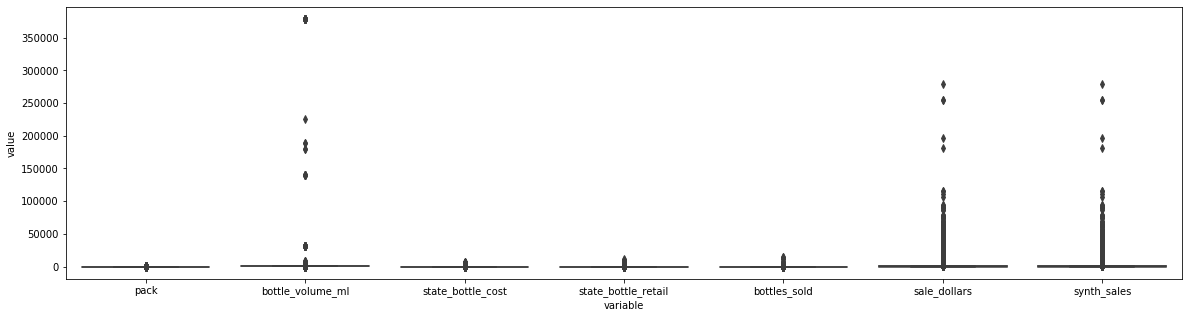

In [58]:
fig = plt.figure(figsize=(20, 5))
sns.boxplot(x='variable', y='value', data=pd.melt(all_items_df[quant_columns]))
fig.show()

Most of the outlier values is much greater than 1.5IQR, so we need to remove them and estimate the impact on the dataset.

In [59]:
df = all_items_df.copy()
# filtering sales column and drop empty values
synth_sales_q1 = all_items_df['synth_sales'].quantile(0.25)
synth_sales_q3 = all_items_df['synth_sales'].quantile(0.75)
synth_sales_iqr = synth_sales_q3 - synth_sales_q1

bottle_vol_q1 = all_items_df['bottle_volume_ml'].quantile(0.25)
bottle_vol_q3 = all_items_df['bottle_volume_ml'].quantile(0.75)
bottle_vol_iqr = bottle_vol_q3 - bottle_vol_q1

df.query('@synth_sales_q1 - 1.5 * @synth_sales_iqr <= synth_sales <= @synth_sales_q3 + 1.5 * @synth_sales_iqr', inplace=True)
df.query('@bottle_vol_q1 - 1.5 * @bottle_vol_iqr <= bottle_volume_ml <= @bottle_vol_q3 + 1.5 * @bottle_vol_iqr''', inplace=True)

# removing unnecessary columns
df.drop(['sale_dollars'], axis=1, inplace=True)

df.shape

(12401067, 15)

In [0]:
quant_columns = ['pack', 
                 'bottle_volume_ml', 
                 'state_bottle_cost',
                 'state_bottle_retail',
                 'bottles_sold',
                 'synth_sales']

In [61]:
df.head()

,store_number,address,city,zip_code,store_location,county_number,category,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,synth_sales
date,,,,,,,,,,,,,,,
2016-03-31,2248,3500 INGERSOLL AVE,DES MOINES,50312,POINT (-93.664182 41.586319),77,1012200,35,902365,10,603,11.95,17.930000,10,179.300003
2014-10-01,3869,412 1ST AVE,CORALVILLE,52241,POINT (-91.565517 41.672672),52,1701100,492,4047,6,400,6.01,9.020000,6,54.120003
2016-08-29,2573,2400 2nd Ave,Muscatine,52761,POINT (-91.035138 41.451349),70,1070000,434,63522,6,800,3.55,5.330000,2,10.660000
2019-12-17,5444,11 N 3rd Ave,Marshalltown,50158,POINT (-92.908013 42.050021),64,1701100,260,100795,6,850,21.49,32.240002,3,96.720001
2014-11-17,3549,1414 48TH ST,FORT MADISON,52627,POINT (-91.373211 40.62422600000001),56,1701100,492,3981,6,850,17.00,25.500000,6,153.000000


In [62]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, '.2f')))

,store_number,zip_code,county_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,synth_sales
count,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00,12401067.00
mean,3650.62,51001.26,47.91,259.57,48683.51,12.74,720.30,9.17,13.69,7.31,80.60
std,1007.74,3845.35,102.82,139.47,57037.17,4.38,183.87,6.41,9.61,6.72,68.51
min,2106.00,-999.00,-999.00,-999.00,-999.00,1.00,375.00,0.00,0.00,0.00,0.00
25%,2605.00,50315.00,31.00,115.00,28086.00,12.00,750.00,5.01,7.64,2.00,26.40
50%,3762.00,51055.00,61.00,260.00,41693.00,12.00,750.00,7.53,11.30,5.00,60.12
75%,4461.00,52303.00,77.00,380.00,65426.00,12.00,750.00,11.34,17.01,12.00,121.56
max,9937.00,80904.00,99.00,987.00,999449.00,60.00,1200.00,195.00,292.50,180.00,295.71


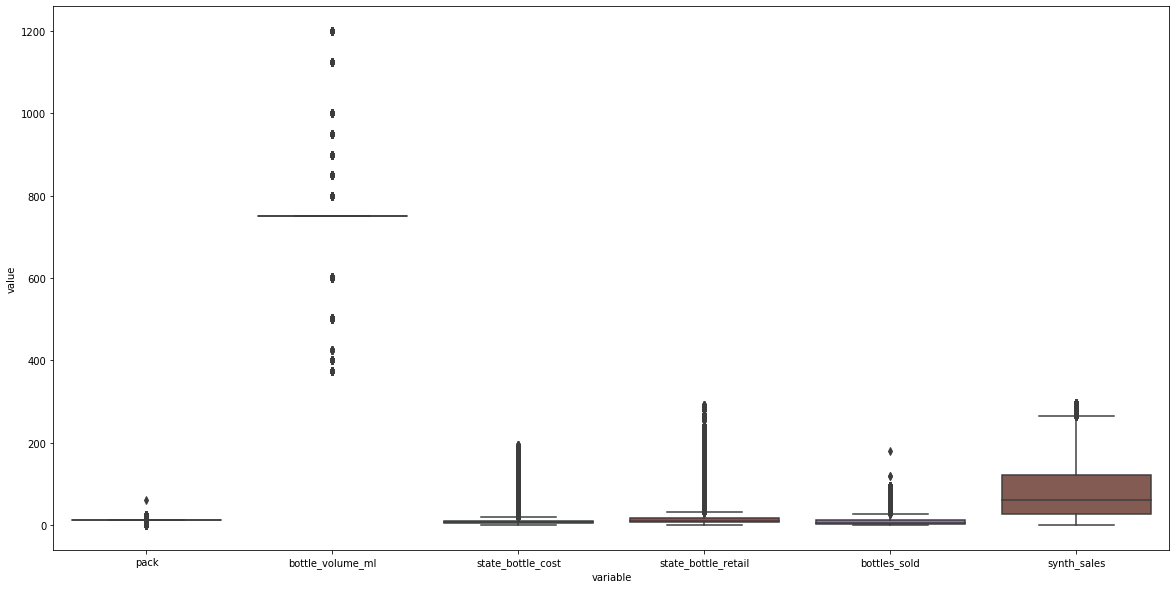

In [63]:
fig = plt.figure(figsize=(20, 10)) 
sns.boxplot(x='variable', y='value', data=pd.melt(df[quant_columns]))
fig.show()

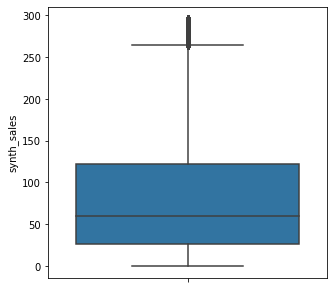

In [64]:
fig = plt.figure(figsize=(5, 5)) 
sns.boxplot(y='synth_sales', data=df)
fig.show()

In [0]:
sales_monthly = pd.DataFrame(df['synth_sales'].groupby(pd.Grouper(freq='M')).sum())
sales_monthly['all_sales'] = all_items_df['synth_sales'].groupby(pd.Grouper(freq='M')).sum()
sales_monthly['sales_ma'] = sales_monthly['synth_sales'].rolling(6).mean()

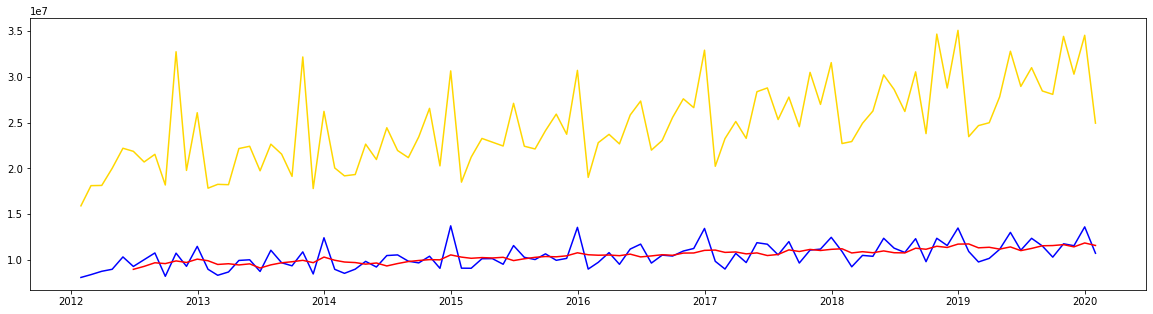

In [66]:
fig = plt.figure(figsize=(20, 5))
plt.plot(sales_monthly.index, sales_monthly.synth_sales, color='blue')
plt.plot(sales_monthly.index, sales_monthly.sales_ma, color='red')
plt.plot(sales_monthly.index, sales_monthly.all_sales, color='gold')
fig.show()

The figure above shows:
1. Strong seasonal patern
2. Sales ammount is on positive trend
3. Timeseries is unstationary, so it should be normalized for further processing
4. Outliers, removed from the dataset makes up an important part of sales so can't be easily excluded
5. The most differences is in the seasonal peaks - investigation of this point can show which costly alco items are trendy in the specific season
6. Line which include all items growth faster than filtered - it can means that consumption of high price drinks grows, or people prefer to by it by bigger groups.

In [0]:
corr_df = all_items_df.corr()

In [79]:
corr_df

,store_number,zip_code,county_number,vendor_number,item_number,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,synth_sales
store_number,1.000000,-0.019903,-0.037591,0.001128,-0.022919,0.105401,-0.058971,-0.044464,-0.044687,0.005125,-0.025130,-0.025443
zip_code,-0.019903,1.000000,0.635329,-0.000342,0.001171,-0.005460,0.004056,-0.001956,-0.001916,0.000125,-0.001756,-0.001885
county_number,-0.037591,0.635329,1.000000,-0.000690,0.002731,-0.007233,0.001170,0.003857,0.003907,0.005278,0.005048,0.004970
vendor_number,0.001128,-0.000342,-0.000690,1.000000,0.129516,-0.038652,0.010868,0.006443,0.006189,0.010737,-0.004478,-0.004414
item_number,-0.022919,0.001171,0.002731,0.129516,1.000000,-0.022789,-0.023381,0.085852,0.085724,0.020549,0.026591,0.026378
pack,0.105401,-0.005460,-0.007233,-0.038652,-0.022789,1.000000,-0.454334,-0.253085,-0.253460,0.121091,-0.047366,-0.047397
bottle_volume_ml,-0.058971,0.004056,0.001170,0.010868,-0.023381,-0.454334,1.000000,0.449952,0.450294,-0.014374,0.062706,0.062701
state_bottle_cost,-0.044464,-0.001956,0.003857,0.006443,0.085852,-0.253085,0.449952,1.000000,0.999966,-0.040004,0.102098,0.102311
state_bottle_retail,-0.044687,-0.001916,0.003907,0.006189,0.085724,-0.253460,0.450294,0.999966,1.000000,-0.039998,0.102141,0.102359
bottles_sold,0.005125,0.000125,0.005278,0.010737,0.020549,0.121091,-0.014374,-0.040004,-0.039998,1.000000,0.837526,0.837378


In [0]:
mask = np.zeros_like(corr_df.values)
mask[np.triu_indices_from(mask)] = True

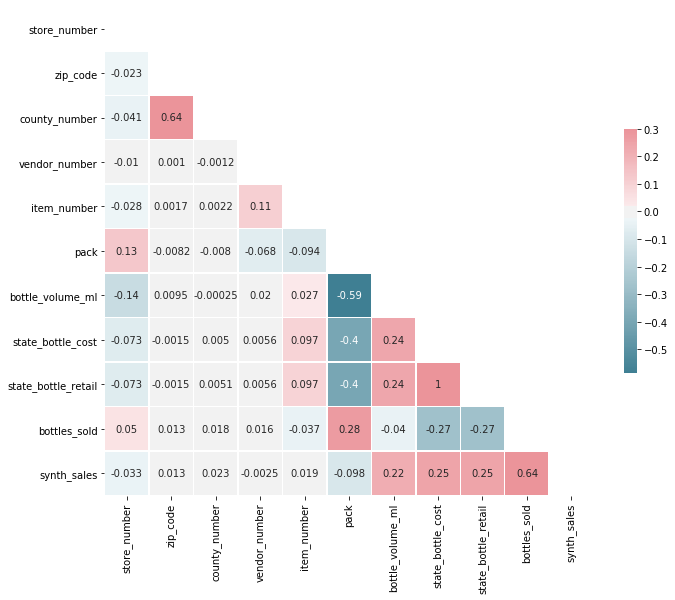

In [87]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, mask=mask)
f.show()

And here is few interesting correlations:
1. First thing - strong negative correlation between bottle volume and q-ty of bottles in pack
2. Also there in negative correlation between bottle cost and q-ty in pack.



# Valuable information that can be presented for business:
1. Market analysis - sales trend, seasonal decomposition for demand planning, split by cities / counties, sales predictions (Holt-Winters, ARIMA, etc.)
2. Existing prices on the market for items, categories, trends and dynamics over time.
3. If to add information about population in the cities - average alcohol consumption for person, cities where demand is higher than proposal (city demand - avg state demand)
4. Competitors analysis - items range for every / most trending vendors, popular items which are not presented in the market, vendor price segment.
5. Cities with low competition - where only few vendors presented (better to match with population info)
6. Trending items by volumes over time.